In [1]:
import numpy as np 
import math
import pandas as pd 
import collections
from itertools import permutations
import string

# Loading the dataset

The *languages_dataset* is a collection of 2000 sentences in 3 different languages (Algerian dialect Daridja, French and English) along with their corresponding language labels. The columns are:
- *Sentence*: Contains sentences in various languages.
- *Language*: Corresponding language label, indicating the language of each sentence.

The sentences were manualluy collected from different data sources (social media posts and comments, books, blogs, electronic documents ... etc).

The aim of this project is to create a model that can differenciate between the 3 languages and be able to classify sentences correctly according to their corresponding language.

In [2]:
df = pd.read_csv("languages_dataset2.csv", encoding='ANSI', header=0)

In [3]:
df.head(10)

,Sentence,Language
0,Il lit les nouvelles.,French
1,ajmal haja f denia post control w zidlo dar,Daridja
2,"Si on n'a rien de prêt pour le diner,",French
3,Another bad hair day.,English
4,Salam oualikoum wa rahmat ellah wa barakatouh,Daridja
5,"faire des courses, aller chercher les enfants ...",French
6,bedloulha le prix ... tla3 bezzaaaf,Daridja
7,More honoured in the breach than in the observ...,English
8,Ship shape and Bristol fashion,English
9,donc khliwlna ndiro sondage khir w khir .,Daridja


In [4]:
unique_values = df['Language'].unique()
unique_values

array(['French', 'Daridja', 'English'], dtype=object)

In [5]:
language_counts = df['Language'].value_counts()
language_counts

Language
English    830
French     650
Daridja    545
Name: count, dtype: int64

In [6]:
df.dtypes

Sentence    object
Language    object
dtype: object

We remark that the type of the data is **object**, wheras we want it to be **string**. We can change that using the following code:

In [7]:
df['Sentence'] = df['Sentence'].astype(str)
df['Language'] = df['Language'].astype(str)

In [8]:
df.describe()

,Sentence,Language
count,2025,2025
unique,1980,3
top,nan,English
freq,5,830


As shown in the output, the behavior of describe() is different with a series of strings. Different stats were returned like the total count of values, the number of unique ones, top repeated values and their frequency of occurrence. 

When analyzing this output, we can conclude the following 2 points:
- There are 5 NaN values that we need to remove (empty strings).
- The total number of sentences is 2025, of which there are 1980 unique ones. This implies the existence of duplicates that we need to remove.

In [9]:
# We start by dropping NaN values (empty strings in our case).
df.dropna(subset=['Sentence'], inplace=True)

In [10]:
# Removing the duplicate lines
df.drop_duplicates(subset=['Sentence'], inplace=True)

In [11]:
df.describe()

,Sentence,Language
count,1980,1980
unique,1980,3
top,Il lit les nouvelles.,English
freq,1,830


By running the describe method again, we can see that now all sentences are repeated only once and that empty strings are no longer in the dataset.

# Feature engineering

In [12]:
punc = string.punctuation # The different punctuation marks
vowels = ['a', 'e', 'i', 'o', 'u', 'é', 'è', 'ê', 'à', 'â', 'î']
daridja_replacement_numbers = ['2', '3', '5', '6', '7', '9'] # Numbers used to replace pronounciation of certain arabic letters 
                                                            # which are respectively : ['ق', 'ح', 'ت', 'خ', 'ع', 'أ']
french_articles = ['la', 'le', 'les', 'un', 'des']
english_articles = ['the', 'an']

# Create a pre-defined set of features for the Sentence column
df['word_count'] = df['Sentence'].apply(lambda x: len(x.split()))
df['character_count'] = df['Sentence'].apply(lambda x: len(x.replace(" ", "")))
df['word_density'] = df['word_count'] / (df['character_count'] + 1)
df['num_vowels'] = df['Sentence'].apply(lambda x: sum(1 for char in x if char.lower() in vowels))
df['vowel_density'] = df['num_vowels']/df['word_count']
df['capitals'] = df['Sentence'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['character_count']),axis=1)
df['punc_count'] = df['Sentence'].apply(lambda x: len([a for a in x if a in punc]))
df['num_repeated_words'] = df['Sentence'].apply(lambda x: len([w for w in collections.Counter(x.split()).values() if w > 1]))

# Features specific to French
df['num_accented_chars'] = df['Sentence'].apply(lambda x: sum([1 for a in x if a in ['é', 'è', 'ê', 'à', 'â', 'î', 'ô', 'û', 'É', 'È', 'Ê', 'À', 'Â', 'Î', 'Ô', 'Û']]))
df['num_apostrophes'] = df['Sentence'].apply(lambda x: x.count("'"))
df['num_french_articles'] = df['Sentence'].apply(lambda x: sum(1 for word in x.split() if word.lower() in french_articles and len(word) == len(word.strip())))

# Features specific to Daridja
df['num_arabic_replacements'] = df['Sentence'].apply(lambda x: sum([1 for a in x if a in daridja_replacement_numbers]))

# Features specific to English
df['num_english_articles'] = df['Sentence'].apply(lambda x: sum(1 for word in x.split() if word.lower() in english_articles and len(word) == len(word.strip())))

In [13]:
df.head(15)

,Sentence,Language,word_count,character_count,word_density,num_vowels,vowel_density,capitals,caps_vs_length,punc_count,num_repeated_words,num_accented_chars,num_apostrophes,num_french_articles,num_arabic_replacements,num_english_articles
0,Il lit les nouvelles.,French,4,18,0.210526,7,1.750000,1,0.055556,1,0,0,0,1,0,0
1,ajmal haja f denia post control w zidlo dar,Daridja,9,35,0.250000,13,1.444444,0,0.000000,0,0,0,0,0,0,0
2,"Si on n'a rien de prêt pour le diner,",French,9,29,0.300000,12,1.333333,1,0.034483,2,0,1,1,1,0,0
3,Another bad hair day.,English,4,18,0.210526,7,1.750000,1,0.055556,1,0,0,0,0,0,0
4,Salam oualikoum wa rahmat ellah wa barakatouh,Daridja,7,39,0.175000,19,2.714286,1,0.025641,0,1,0,0,0,0,0
5,"faire des courses, aller chercher les enfants ...",French,9,48,0.183673,18,2.000000,0,0.000000,3,0,2,1,2,0,0
6,bedloulha le prix ... tla3 bezzaaaf,Daridja,6,30,0.193548,11,1.833333,0,0.000000,3,0,0,0,1,1,0
7,More honoured in the breach than in the observ...,English,9,43,0.204545,17,1.888889,1,0.023256,1,2,0,0,0,0,2
8,Ship shape and Bristol fashion,English,5,26,0.185185,9,1.800000,2,0.076923,0,0,0,0,0,0,0
9,donc khliwlna ndiro sondage khir w khir .,Daridja,8,34,0.228571,10,1.250000,0,0.000000,1,1,0,0,0,0,0


In [14]:
# Calculate the mean value of each numerical feature for each language group
df.groupby('Language').mean(numeric_only=True).T

Language,Daridja,English,French
word_count,6.224490,5.921687,7.322422
character_count,28.923933,25.922892,35.302782
word_density,0.206098,0.225235,0.205376
num_vowels,10.359926,9.407229,14.761047
vowel_density,1.752660,1.632575,2.055179
capitals,1.107607,1.285542,1.328969
caps_vs_length,0.037992,0.063627,0.046266
punc_count,0.497217,0.898795,1.803601
num_repeated_words,0.120594,0.154217,0.180033
num_accented_chars,0.063080,0.000000,1.106383


After creating the set of features, it is now necessary to encode the *Language* column. For this we will use Label Encoding.

In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the Language column
df['Language_encoded'] = label_encoder.fit_transform(df['Language'])

# Print the mapping of original labels to encoded values
print("Encoded values for languages:")
for label, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded_value}")

Encoded values for languages:
Daridja: 0
English: 1
French: 2


In [16]:
df.head()

,Sentence,Language,word_count,character_count,word_density,num_vowels,vowel_density,capitals,caps_vs_length,punc_count,num_repeated_words,num_accented_chars,num_apostrophes,num_french_articles,num_arabic_replacements,num_english_articles,Language_encoded
0,Il lit les nouvelles.,French,4,18,0.210526,7,1.750000,1,0.055556,1,0,0,0,1,0,0,2
1,ajmal haja f denia post control w zidlo dar,Daridja,9,35,0.250000,13,1.444444,0,0.000000,0,0,0,0,0,0,0,0
2,"Si on n'a rien de prêt pour le diner,",French,9,29,0.300000,12,1.333333,1,0.034483,2,0,1,1,1,0,0,2
3,Another bad hair day.,English,4,18,0.210526,7,1.750000,1,0.055556,1,0,0,0,0,0,0,1
4,Salam oualikoum wa rahmat ellah wa barakatouh,Daridja,7,39,0.175000,19,2.714286,1,0.025641,0,1,0,0,0,0,0,0


In [17]:
# After encoding the Language column into numerical labels and adding a new column for the encoded values, we can drop the original Language column.
df.drop(columns=['Language'], inplace=True)

In [18]:
df.head()

,Sentence,word_count,character_count,word_density,num_vowels,vowel_density,capitals,caps_vs_length,punc_count,num_repeated_words,num_accented_chars,num_apostrophes,num_french_articles,num_arabic_replacements,num_english_articles,Language_encoded
0,Il lit les nouvelles.,4,18,0.210526,7,1.750000,1,0.055556,1,0,0,0,1,0,0,2
1,ajmal haja f denia post control w zidlo dar,9,35,0.250000,13,1.444444,0,0.000000,0,0,0,0,0,0,0,0
2,"Si on n'a rien de prêt pour le diner,",9,29,0.300000,12,1.333333,1,0.034483,2,0,1,1,1,0,0,2
3,Another bad hair day.,4,18,0.210526,7,1.750000,1,0.055556,1,0,0,0,0,0,0,1
4,Salam oualikoum wa rahmat ellah wa barakatouh,7,39,0.175000,19,2.714286,1,0.025641,0,1,0,0,0,0,0,0


Now, let's check the degree of correlation between the features and the languages.

In [19]:
# Calculate the correlation matrix
correlation_matrix = df.corr(method='pearson', numeric_only=True)

# Extract correlations with Language_encoded column
language_correlation = correlation_matrix['Language_encoded']

# Print correlations
print("Correlation of each feature with Language_encoded:")
print(language_correlation)

Correlation of each feature with Language_encoded:
word_count                 0.130750
character_count            0.161831
word_density              -0.012976
num_vowels                 0.263389
vowel_density              0.199798
capitals                   0.031738
caps_vs_length             0.031876
punc_count                 0.432316
num_repeated_words         0.049507
num_accented_chars         0.487322
num_apostrophes            0.284308
num_french_articles        0.425275
num_arabic_replacements   -0.450711
num_english_articles      -0.018302
Language_encoded           1.000000
Name: Language_encoded, dtype: float64


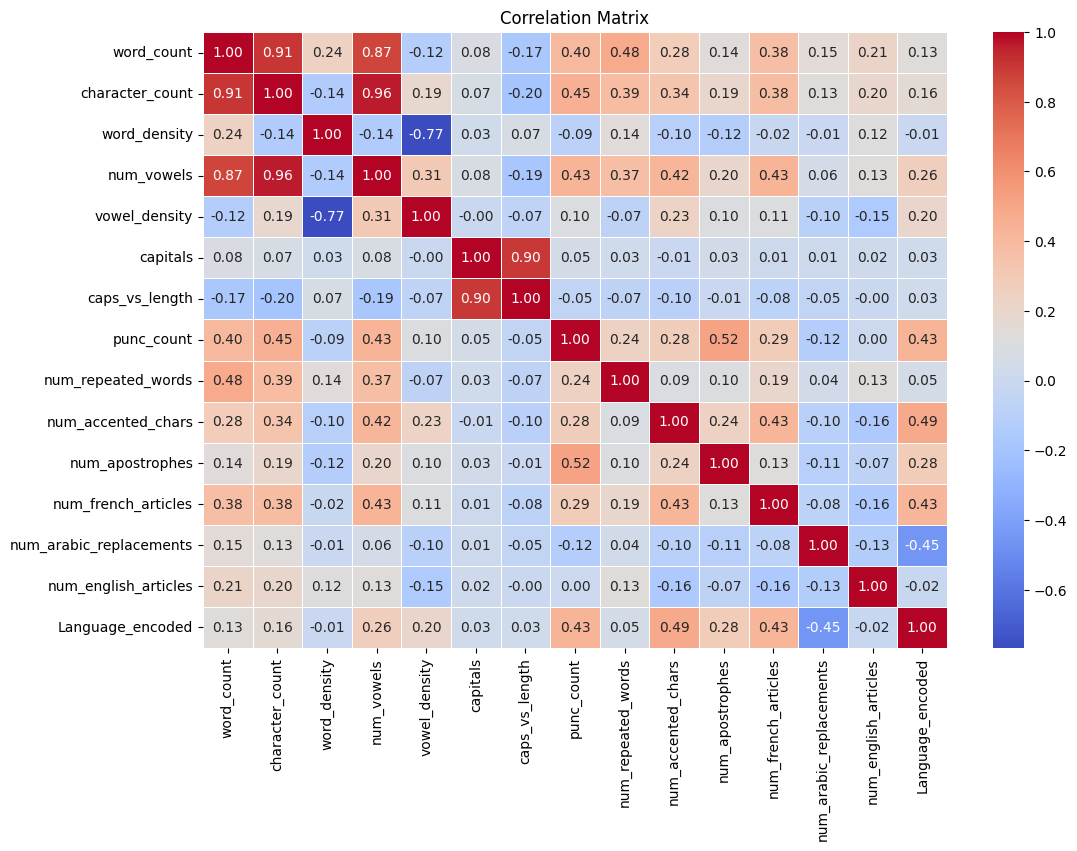

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The feautures: **num_vowels**, **vowel_density**, **punc_count**, **num_accented_chars**, **num_apostrophes**, **num_french_articles** have **positive** correlations with language labels. This suggests that sentences with more vowels, higher vowel density, more punctuation marks, more accented characters, more apostrophes, and more French articles are **indicative** of certain languages.

The feautures: **num_arabic_replacements**, and **num_english_articles** have **negative** correlations with language labels. This suggests that sentences with more Arabic replacements and more English articles are **indicative** of different languages.

Whereas **word_density**, **capitals**, and **caps_vs_length** have correlations **close to zero**, indicating a **weak** relationship with language labels.

We can eliminate the **word_density**, **capitals**, and **caps_vs_length** columns as they have the weakest correlation with the language column.

In [21]:
df.drop(columns=['word_density', 'capitals', 'caps_vs_length'], inplace=True)

## Data Splitting and Normalization

First, we separate the features matrix X from the target column y.

In [22]:
X = df.drop(columns=['Sentence', 'Language_encoded'])  # Exclude 'Sentence' and 'Language_encoded' columns from features
y = df['Language_encoded']  # Target variable is 'Language_encoded'

Now, we apply data normalization using the StandardScaler from sklearn.

In [23]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

Then we split the dataset into training and testing sets.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y, test_size=0.2, random_state=0)

## Applying the ML Models

### 1.1 Decision tree on non-normalized data

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

To apply the decision tree model, we need to find the best parameters that fit our dataset. For this, we will use the grid search as follows:

In [26]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = DecisionTreeClassifier(random_state=0)

grid_search_dtree = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search_dtree.fit(X_train, y_train)

best_params = grid_search_dtree.best_params_
print("Best parameters found by grid search:", best_params)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1

**NB:** Saving grid search parameters ensures reproducibility, saves time by avoiding re-running the search, and facilitates sharing and comparing models. So I will save them using pickle as follows:

In [27]:
import pickle

with open('grid_search_dtree.pkl', 'wb') as file:
    pickle.dump(grid_search_dtree, file)

# To use the results next time without re-running, use the following code: 
# with open('grid_search_dtree_model.pkl', 'rb') as file:
#     grid_search_dtree = pickle.load(file)

NameError: name 'grid_search_dtree' is not defined

In [28]:
best_clf = grid_search_dtree.best_estimator_
y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8585858585858586
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       100
           1       0.82      0.95      0.88       165
           2       0.95      0.82      0.88       131

    accuracy                           0.86       396
   macro avg       0.86      0.84      0.85       396
weighted avg       0.86      0.86      0.86       396



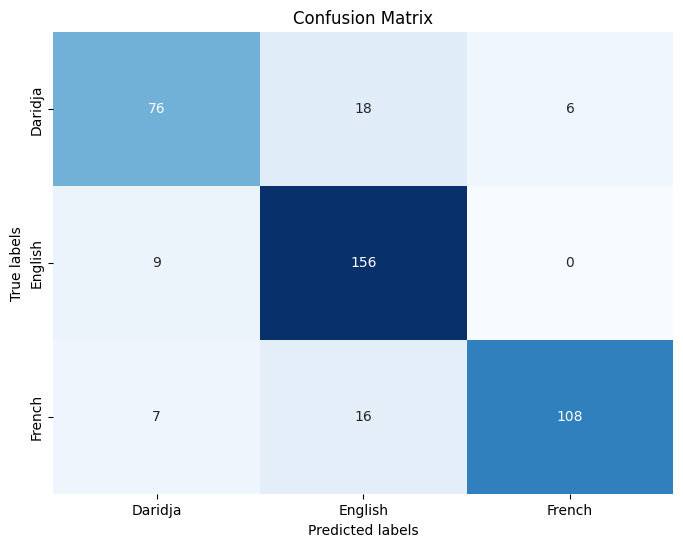

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
label_map = {0: 'Daridja', 1: 'English', 2: 'French'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
tick_labels = [label_map[i] for i in range(len(label_map))]
plt.xticks(ticks=[i+0.5 for i in range(len(label_map))], labels=tick_labels)
plt.yticks(ticks=[i+0.5 for i in range(len(label_map))], labels=tick_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 1.2 Decision tree on normalized data

In [30]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = DecisionTreeClassifier(random_state=42)

grid_search_dtree_norm = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search_dtree_norm.fit(X_train_norm, y_train_norm)

best_params = grid_search_dtree_norm.best_params_
print("Best parameters found by grid search:", best_params)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1

In [31]:
with open('grid_search_dtree_norm.pkl', 'wb') as file:
    pickle.dump(grid_search_dtree_norm, file)

best_clf = grid_search_dtree_norm.best_estimator_
y_pred_norm = best_clf.predict(X_test_norm)

accuracy = accuracy_score(y_test_norm, y_pred_norm)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test_norm, y_pred_norm))

Accuracy: 0.8560606060606061
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       100
           1       0.82      0.95      0.88       165
           2       0.95      0.82      0.88       131

    accuracy                           0.86       396
   macro avg       0.86      0.84      0.85       396
weighted avg       0.86      0.86      0.86       396



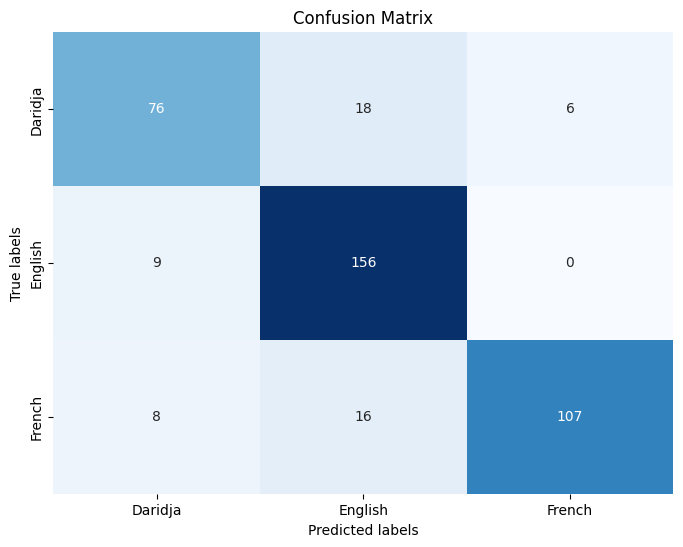

In [32]:
conf_matrix = confusion_matrix(y_test_norm, y_pred_norm)
label_map = {0: 'Daridja', 1: 'English', 2: 'French'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
tick_labels = [label_map[i] for i in range(len(label_map))]
plt.xticks(ticks=[i+0.5 for i in range(len(label_map))], labels=tick_labels)
plt.yticks(ticks=[i+0.5 for i in range(len(label_map))], labels=tick_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 2.1 Naive Bayes on non-normalized data

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0] 
    # By adjusting alpha, we can control the balance between smoothing and the original probabilities derived from the data. 
    # A higher alpha value means stronger smoothing, which can help to generalize better to unseen data but may also oversmooth the estimates. 
    # Conversely, a lower alpha value may lead to overfitting the training data.
}

naive_bayes = MultinomialNB()

In this case of non-normalized dataset, I used **MultinomialNB()** because it's suitable for features with discrete counts since we have features such as **word counts**, **punctuation counts**, **num_accented_chars**, **num_arabic_replacements**... etc.

In [34]:
grid_search_naive = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=5, verbose=2)

# Fit the grid search to the data
grid_search_naive.fit(X_train, y_train)

with open('grid_search_naive.pkl', 'wb') as file:
    pickle.dump(grid_search_naive, file)

# Best parameter after grid search
print("Best parameter:", grid_search_naive.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ........................................

In [36]:
y_pred = grid_search_naive.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7904040404040404


### 2.2 Naive Bayes on normalized data

In [44]:
from sklearn.naive_bayes import GaussianNB

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

naive_bayes = GaussianNB()

In the case of normalized dataset, the values of the features are continuous, so we would rather use **GaussianNB()**.

In [46]:
grid_search_naive_norm = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search_naive_norm.fit(X_train_norm, y_train_norm)

with open('grid_search_naive_norm.pkl', 'wb') as file:
    pickle.dump(grid_search_dtree_norm, file)

best_params = grid_search_naive_norm.best_params_

best_nb_model = GaussianNB(**best_params)
best_nb_model.fit(X_train_norm, y_train_norm)

# Evaluate the model
accuracy = best_nb_model.score(X_test_norm, y_test_norm)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.7803030303030303


### 3.1 Random Forest on non-normalized data

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [28]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier(random_state=0)

# Perform grid search
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, verbose=2)
grid_search_rf.fit(X_train, y_train)

with open('grid_search_rf.pkl', 'wb') as file:
    pickle.dump(grid_search_rf, file)

# Get the best parameters
best_params = grid_search_rf.best_params_
print("Best Parameters found by grid search:", best_params)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf

In [29]:
best_rf_model = RandomForestClassifier(random_state=42, **grid_search_rf.best_params_)
best_rf_model.fit(X_train, y_train)

accuracy = best_rf_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8737373737373737


In [30]:
from sklearn.metrics import classification_report

# Make predictions using the best model
y_pred = best_rf_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       100
           1       0.81      0.96      0.88       165
           2       0.97      0.82      0.89       131

    accuracy                           0.87       396
   macro avg       0.89      0.86      0.87       396
weighted avg       0.88      0.87      0.87       396



### 3.2 Random Forest on normalized data

In [51]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier(random_state=0)

# Perform grid search
grid_search_rf_norm = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, verbose=2)
grid_search_rf_norm.fit(X_train_norm, y_train_norm)

with open('grid_search_rf_norm.pkl', 'wb') as file:
    pickle.dump(grid_search_rf_norm, file)

# Get the best parameters
best_params = grid_search_rf_norm.best_params_
print("Best Parameters found by grid search:", best_params)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf

In [52]:
best_rf_model = RandomForestClassifier(random_state=42, **grid_search_rf_norm.best_params_)
best_rf_model.fit(X_train_norm, y_train_norm)

accuracy = best_rf_model.score(X_test_norm, y_test_norm)
print("Accuracy:", accuracy)

Accuracy: 0.8737373737373737


### 4.1 Logistic Regression on non-normalized data

In [90]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.001, 0.01, 0.5, 1]
}

logistic_regression = LogisticRegression(max_iter=1000)

grid_search_logistic = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=10, verbose=2)

grid_search_logistic.fit(X_train, y_train)

with open('grid_search_logistic.pkl', 'wb') as file:
    pickle.dump(grid_search_logistic, file)
    
print("Best parameter:", grid_search_logistic.best_params_)

best_logistic_regression = LogisticRegression(**grid_search_logistic.best_params_, max_iter=1000)

best_logistic_regression.fit(X_train, y_train)

y_pred = best_logistic_regression.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .......................................

### 4.2 Logistic Regression on normalized data

In [89]:
param_grid = {
    'C': [0.001, 0.01, 0.5, 1]
}

logistic_regression = LogisticRegression(max_iter=1000)

grid_search_logistic_norm = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=10, verbose=2)

grid_search_logistic_norm.fit(X_train_norm, y_train_norm)

with open('grid_search_logistic_norm.pkl', 'wb') as file:
    pickle.dump(grid_search_logistic_norm, file)
    
print("Best parameter:", grid_search_logistic_norm.best_params_)

best_logistic_regression = LogisticRegression(**grid_search_logistic_norm.best_params_, max_iter=1000)

best_logistic_regression.fit(X_train_norm, y_train_norm)

y_pred_norm = best_logistic_regression.predict(X_test_norm)

accuracy_norm = accuracy_score(y_test_norm, y_pred_norm)
print("Accuracy:", accuracy_norm)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .......................................

### 5.1 Support Vector Machine on non-normalized data

In [26]:
from sklearn.svm import SVC

In [92]:
param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear', 'poly']
}

svm_model = SVC()
# By setting n_jobs=3, scikit-learn will use 3 CPU cores (my pc has 4 CPU's) to perform the grid search in parallel, 
# which can significantly reduce the time taken to complete the search.
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=4, n_jobs=3)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters found by grid search:", grid_search_svm.best_params_)

Best Parameters found by grid search: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}


In [93]:
import pickle

with open('grid_search_svm.pkl', 'wb') as file:
    pickle.dump(grid_search_svm, file)

In [98]:
with open('grid_search_svm.pkl', 'rb') as file:
    grid_search_svm2 = pickle.load(file)

In [99]:
best_svm_model = grid_search_svm2.best_estimator_
y_pred = best_svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8560606060606061
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       100
           1       0.80      0.94      0.86       165
           2       0.92      0.85      0.89       131

    accuracy                           0.86       396
   macro avg       0.87      0.84      0.85       396
weighted avg       0.86      0.86      0.85       396



### 5.2 Support Vector Machine on normalized data

In [40]:
param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01],
    'kernel': ['poly','rbf', 'linear' ]
}

svm_model = SVC()
# By setting n_jobs=3, scikit-learn will use 3 CPU cores (my pc has 4 CPU's) to perform the grid search in parallel, 
# which can significantly reduce the time taken to complete the search.
grid_search_svm_norm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=4, n_jobs=3)
grid_search_svm_norm.fit(X_train_norm, y_train_norm)

print("Best Parameters found by grid search:", grid_search_svm_norm.best_params_)

Best Parameters found by grid search: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [41]:
import pickle

with open('grid_search_svm_norm.pkl', 'wb') as file:
    pickle.dump(grid_search_svm_norm, file)

In [42]:
best_svm_model = grid_search_svm_norm.best_estimator_
y_pred_norm = best_svm_model.predict(X_test_norm)

accuracy = accuracy_score(y_test_norm, y_pred_norm)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test_norm, y_pred_norm))

Accuracy: 0.8686868686868687
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       100
           1       0.81      0.93      0.87       165
           2       0.92      0.87      0.89       131

    accuracy                           0.87       396
   macro avg       0.89      0.85      0.87       396
weighted avg       0.88      0.87      0.87       396

